This notebook demonstrates how to fine-tune a pre-trained model on a new task, comparing the effect of training the entire network versus only the output layer.
Fine-tuning pre-trained ResNet-50 model on the Oxford Pet Dataset. 

Introduction to the dataset:
The Oxford-IIIT Pet Dataset is a 37 category pet dataset with roughly 200 images for each class created by the Visual Geometry Group at Oxford. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.

In [15]:
# Doing all the necessary imports
import numpy as np 
import pandas as pd 
import torch,torchvision
import torchvision.transforms as T
from fastai.vision.all import *
from torch.optim import AdamW
from fastai.callback.wandb import *
import fastai.vision.all as fastai
import warnings
warnings.filterwarnings("ignore")

In this code snippet, we first set the path to the directory where the Oxford Pet Dataset images are located. The Path class is used to handle file paths conveniently. We then set the base path for the dataset, which helps resolve relative paths correctly. Finally, we use the ls() method to list the contents of the dataset directory, showing the files and subdirectories.

In [7]:
# Set the path to the Oxford Pet Dataset images directory
path = Path('../input/the-oxfordiiit-pet-dataset')/'images'

# Set the base path for the dataset
Path.BASE_PATH = path

# List the contents of the dataset directory
path.ls()


(#7394) [Path('american_pit_bull_terrier_16.jpg'),Path('leonberger_200.jpg'),Path('english_cocker_spaniel_35.jpg'),Path('Siamese_67.jpg'),Path('boxer_77.jpg'),Path('saint_bernard_146.jpg'),Path('american_bulldog_37.jpg'),Path('Sphynx_239.jpg'),Path('Egyptian_Mau_164.jpg'),Path('Birman_116.jpg')...]

In this code snippet, we define a `DataBlock` object to handle the Oxford Pet Dataset. We specify that the dataset consists of images and corresponding categories (labels). The `get_image_files` function is used to retrieve the image files from the dataset directory. We split the dataset randomly into training and validation sets using a validation percentage of 20% and a fixed seed for reproducibility.

To extract labels from the image filenames, we define a regular expression pattern `pat` that matches the label format. The `using_attr` function is then used to apply the `RegexLabeller` with the pattern to extract the labels.

We also define a set of item transformations using `item_tfms`, which includes resizing the images to a size of 224x224 pixels and converting them to tensors.

Next, we load the dataset using the `dataloaders` method of the `DataBlock` object and specify that the data should be moved to the CUDA-enabled GPU for faster processing.

Finally, we display a batch of the dataset using the `show_batch` method, specifying the size of the figure to visualize the images and their labels.

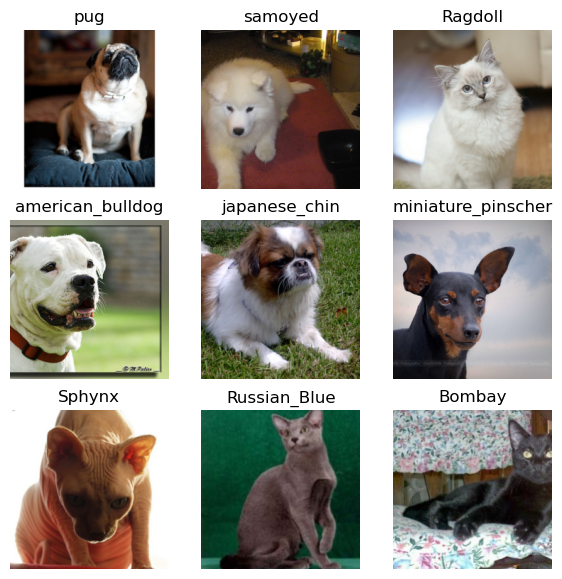

In [8]:
# Define a regular expression pattern to extract labels from image filenames
pat = r'(.+)_\d+.jpg'

# Define a DataBlock for handling the dataset
datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Specify the types of data blocks to use
    get_items=get_image_files,  # Function to retrieve the image files
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Split the dataset into train and validation sets
    get_y=using_attr(RegexLabeller(pat), 'name'),  # Extract labels from filenames using the defined pattern
    item_tfms=[Resize(224), ToTensor()]  # Apply transformations to dataset items
)

# Load the dataset using the defined DataBlock and move it to the GPU
datablock = datablock.dataloaders(path, device='cuda')

# Show a batch of the dataset with a specified figure size
datablock.show_batch(figsize=(7, 7))


In [9]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [10]:
wandb.init(project='resnet50_finetuning')

wandb: Currently logged in as: sharadsingh. Use `wandb login --relogin` to force relogin


In this code snippet, we create a `vision_learner` object by passing the `datablock` and the pre-trained ResNet-50 model (`resnet50`). The `metrics=accuracy` argument specifies that we want to evaluate the accuracy of the model during training. Additionally, we use the `cbs=WandbCallback()` argument to add a callback for integration with the Weights & Biases (wandb) platform, which allows tracking and visualization of model training.

After creating the `learner` object, we call the `fine_tune` method on it, specifying 4 epochs. Fine-tuning is a process where we train the pre-trained model on our specific task (in this case, the Oxford Pet Dataset) by updating the weights of the model based on the dataset. The `fine_tune` method automatically adjusts the learning rates and performs gradual unfreezing of the layers to improve performance on the new task.

In [11]:
learn = vision_learner(datablock, resnet50, metrics=accuracy,cbs=WandbCallback())
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 67.8MB/s]


In this code snippet, we call the `show_results` method on the `learner` object (`learn`). This method displays a set of example images from the validation set along with their corresponding ground truth labels and the predicted labels generated by the model. It provides a visual representation of how well the model is performing on the validation data.


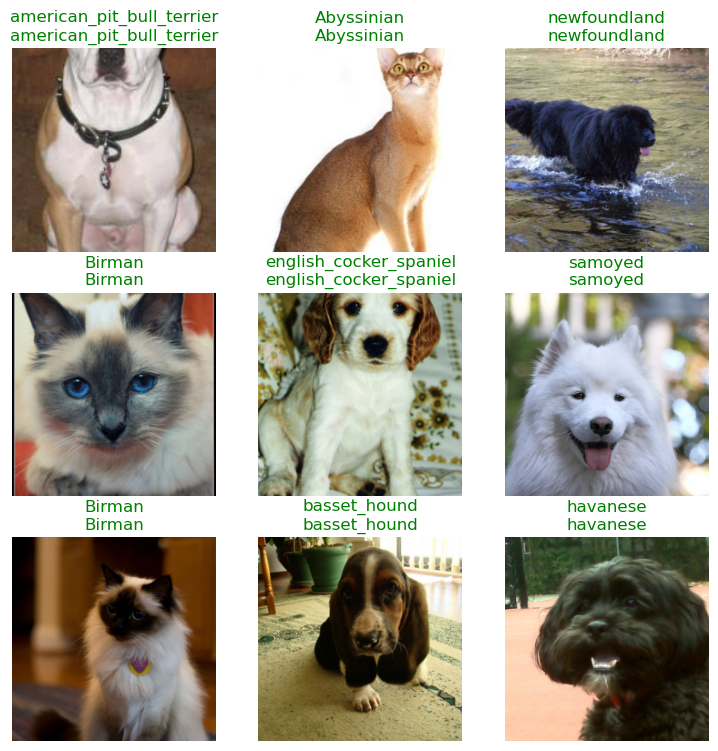

In [12]:
# Show the results of the model predictions
learn.show_results()

In this code snippet, we first create an `Interpretation` object by calling the `from_learner` method and passing the `learner` object (`learn`). The `Interpretation` class provides various methods for interpreting and analyzing the predictions of the model.

Next, we use the `plot_top_losses` method on the `interp` object to visualize the top losses of the model predictions. The method displays a grid of example images where the model had the highest prediction errors. By examining these top loss examples, we can gain insights into the types of images that the model struggles with, which can help in understanding and improving its performance. The `9` argument specifies the number of top loss examples to plot, and the `figsize` argument determines the size of the resulting figure.

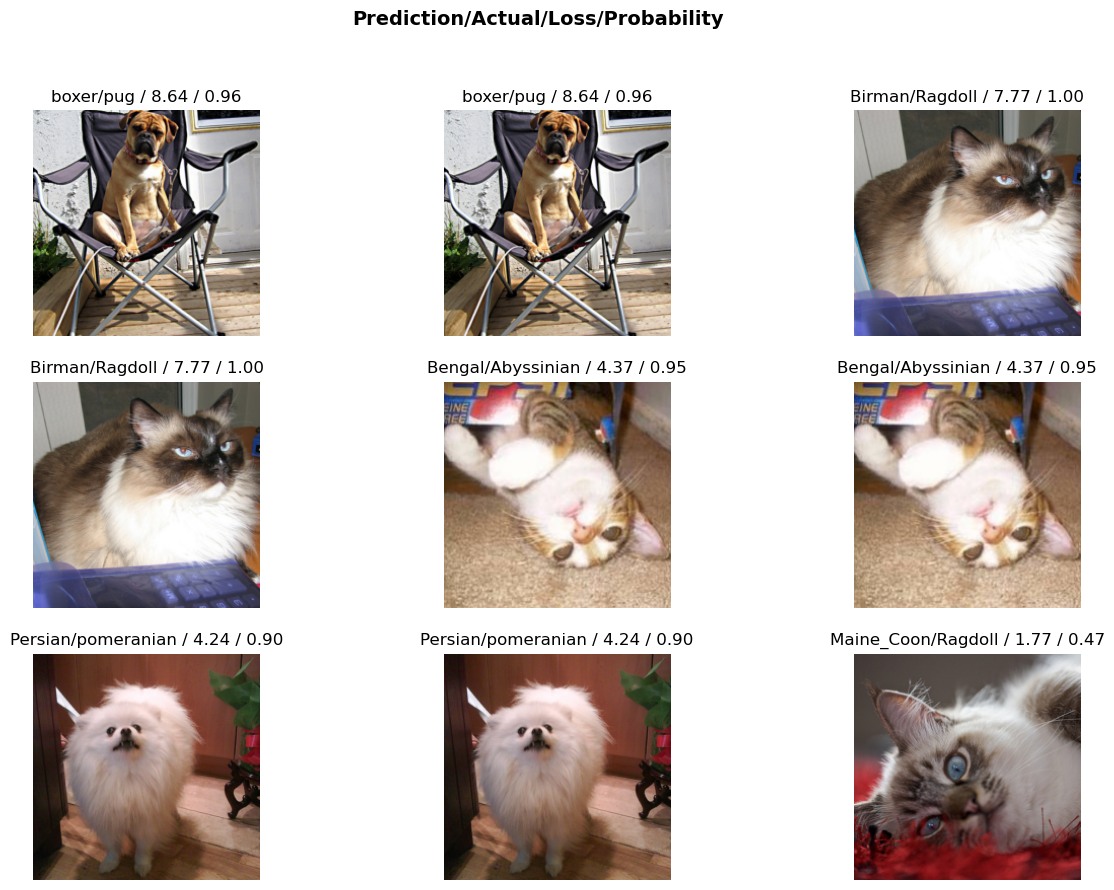

In [13]:
# Create an Interpretation object from the learner
interp = Interpretation.from_learner(learn)

# Plot the top losses of the model predictions
interp.plot_top_losses(9, figsize=(15, 10))


Now let's try a different mechanism and train only the output layer.

In this code snippet, we create a CNN learner object called `learn_output_layer` by passing the `datablock` and the pre-trained ResNet-50 model (`fastai.models.resnet50`). We also specify `metrics=fastai.accuracy` to evaluate the accuracy of the model during training.

Next, we call the `freeze` method on the `learn_output_layer` object. This freezes all the layers in the model except for the output layer. Freezing a layer means that its weights are not updated during training, allowing us to keep the pre-trained weights intact.

In [17]:
learn_output_layer = fastai.cnn_learner(datablock, fastai.models.resnet50, metrics=fastai.accuracy)
learn_output_layer.freeze()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 81.3MB/s]


Finally, we train the model using the `fit_one_cycle` method. This method performs one cycle of training, where the learning rate is gradually increased and then decreased during the training process. We train the model for 4 epochs (`4` as the first argument) and set the maximum learning rate to 1e-3 (`lr_max=1e-3`). The learning rate determines the step size in updating the model's weights during training.

In [19]:
learn_output_layer.fit_one_cycle(4, lr_max=1e-3)

In [20]:
learn_output_layer.validate()

(#2) [0.057723745703697205,0.9824026823043823]

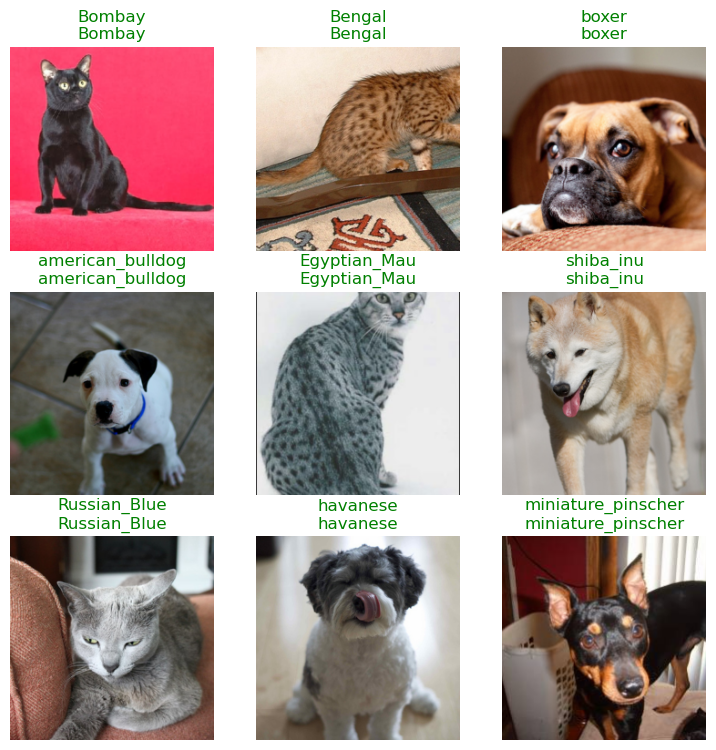

In [22]:
# Show the results of the model predictions
learn_output_layer.show_results()

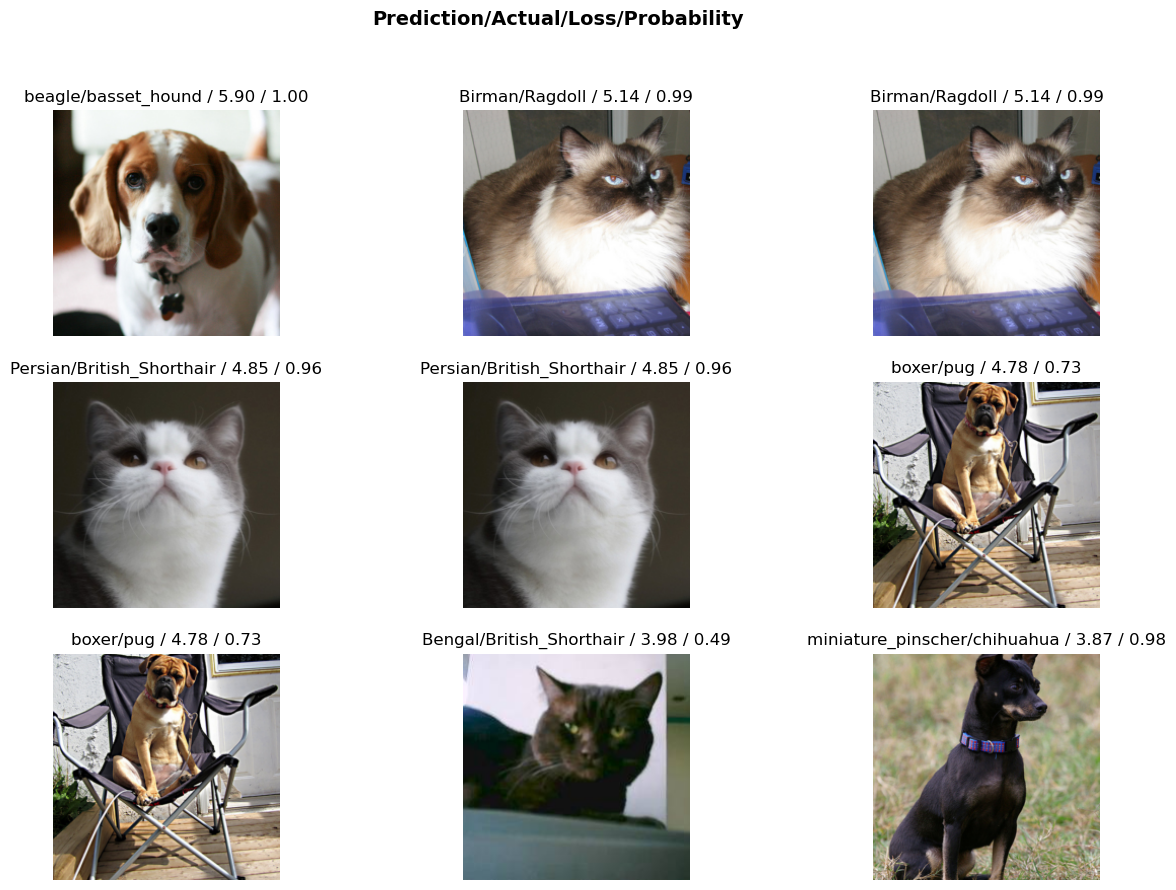

In [23]:
# Create an Interpretation object from the learner
interp2 = Interpretation.from_learner(learn_output_layer)

# Plot the top losses of the model predictions
interp2.plot_top_losses(9, figsize=(15, 10))


These results indicate the impact of the extent of fine-tuning applied to the pre-trained ResNet-50 model when applied to the Oxford Pet Dataset.

When the entire network is fine-tuned (i.e., all layers are trained), the training loss decreases significantly across epochs, and the validation loss follows the same trend. The accuracy achieved is also higher, reaching approximately 99.29% on the validation set after the fourth epoch.

When only the output layer is trained, the model still shows improvement across epochs but at a slower pace. This is evidenced by the higher training and validation losses compared to the scenario where the entire network is fine-tuned. However, the accuracy is also commendable at around 98.24% on the validation set after the fourth epoch.

These results may be due to the fact that by fine-tuning the entire network, the model can learn more specific features from the Oxford Pet Dataset and adjust its weights accordingly. When only the output layer is trained, the model relies heavily on the general features learned from the pre-training data, which may not be optimal for this specific task.

The training time is also worth noting. Fine-tuning the entire network is computationally heavier and takes longer. This difference is apparent in the given data, with fine-tuning the entire network taking roughly 2.5 minutes per epoch, whereas training only the output layer takes less than 2 minutes per epoch.

Overall, this experiment suggests that if computational resources and time are not a constraint, fine-tuning the entire network can lead to better results. However, if these are concerns, training only the output layer still leads to respectable performance and can be considered a reasonable compromise.